<a href="https://colab.research.google.com/github/Ayush7252035/Employee-Attrition-Prediction/blob/main/AttritionPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving employee_data.csv to employee_data (1).csv
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement

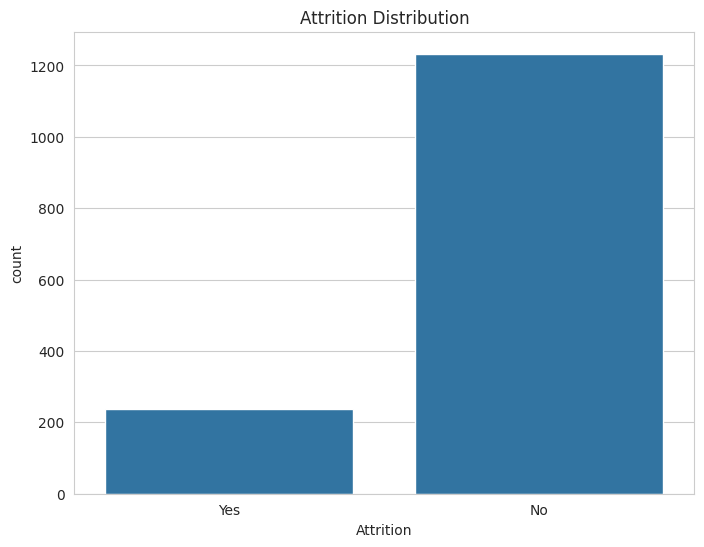

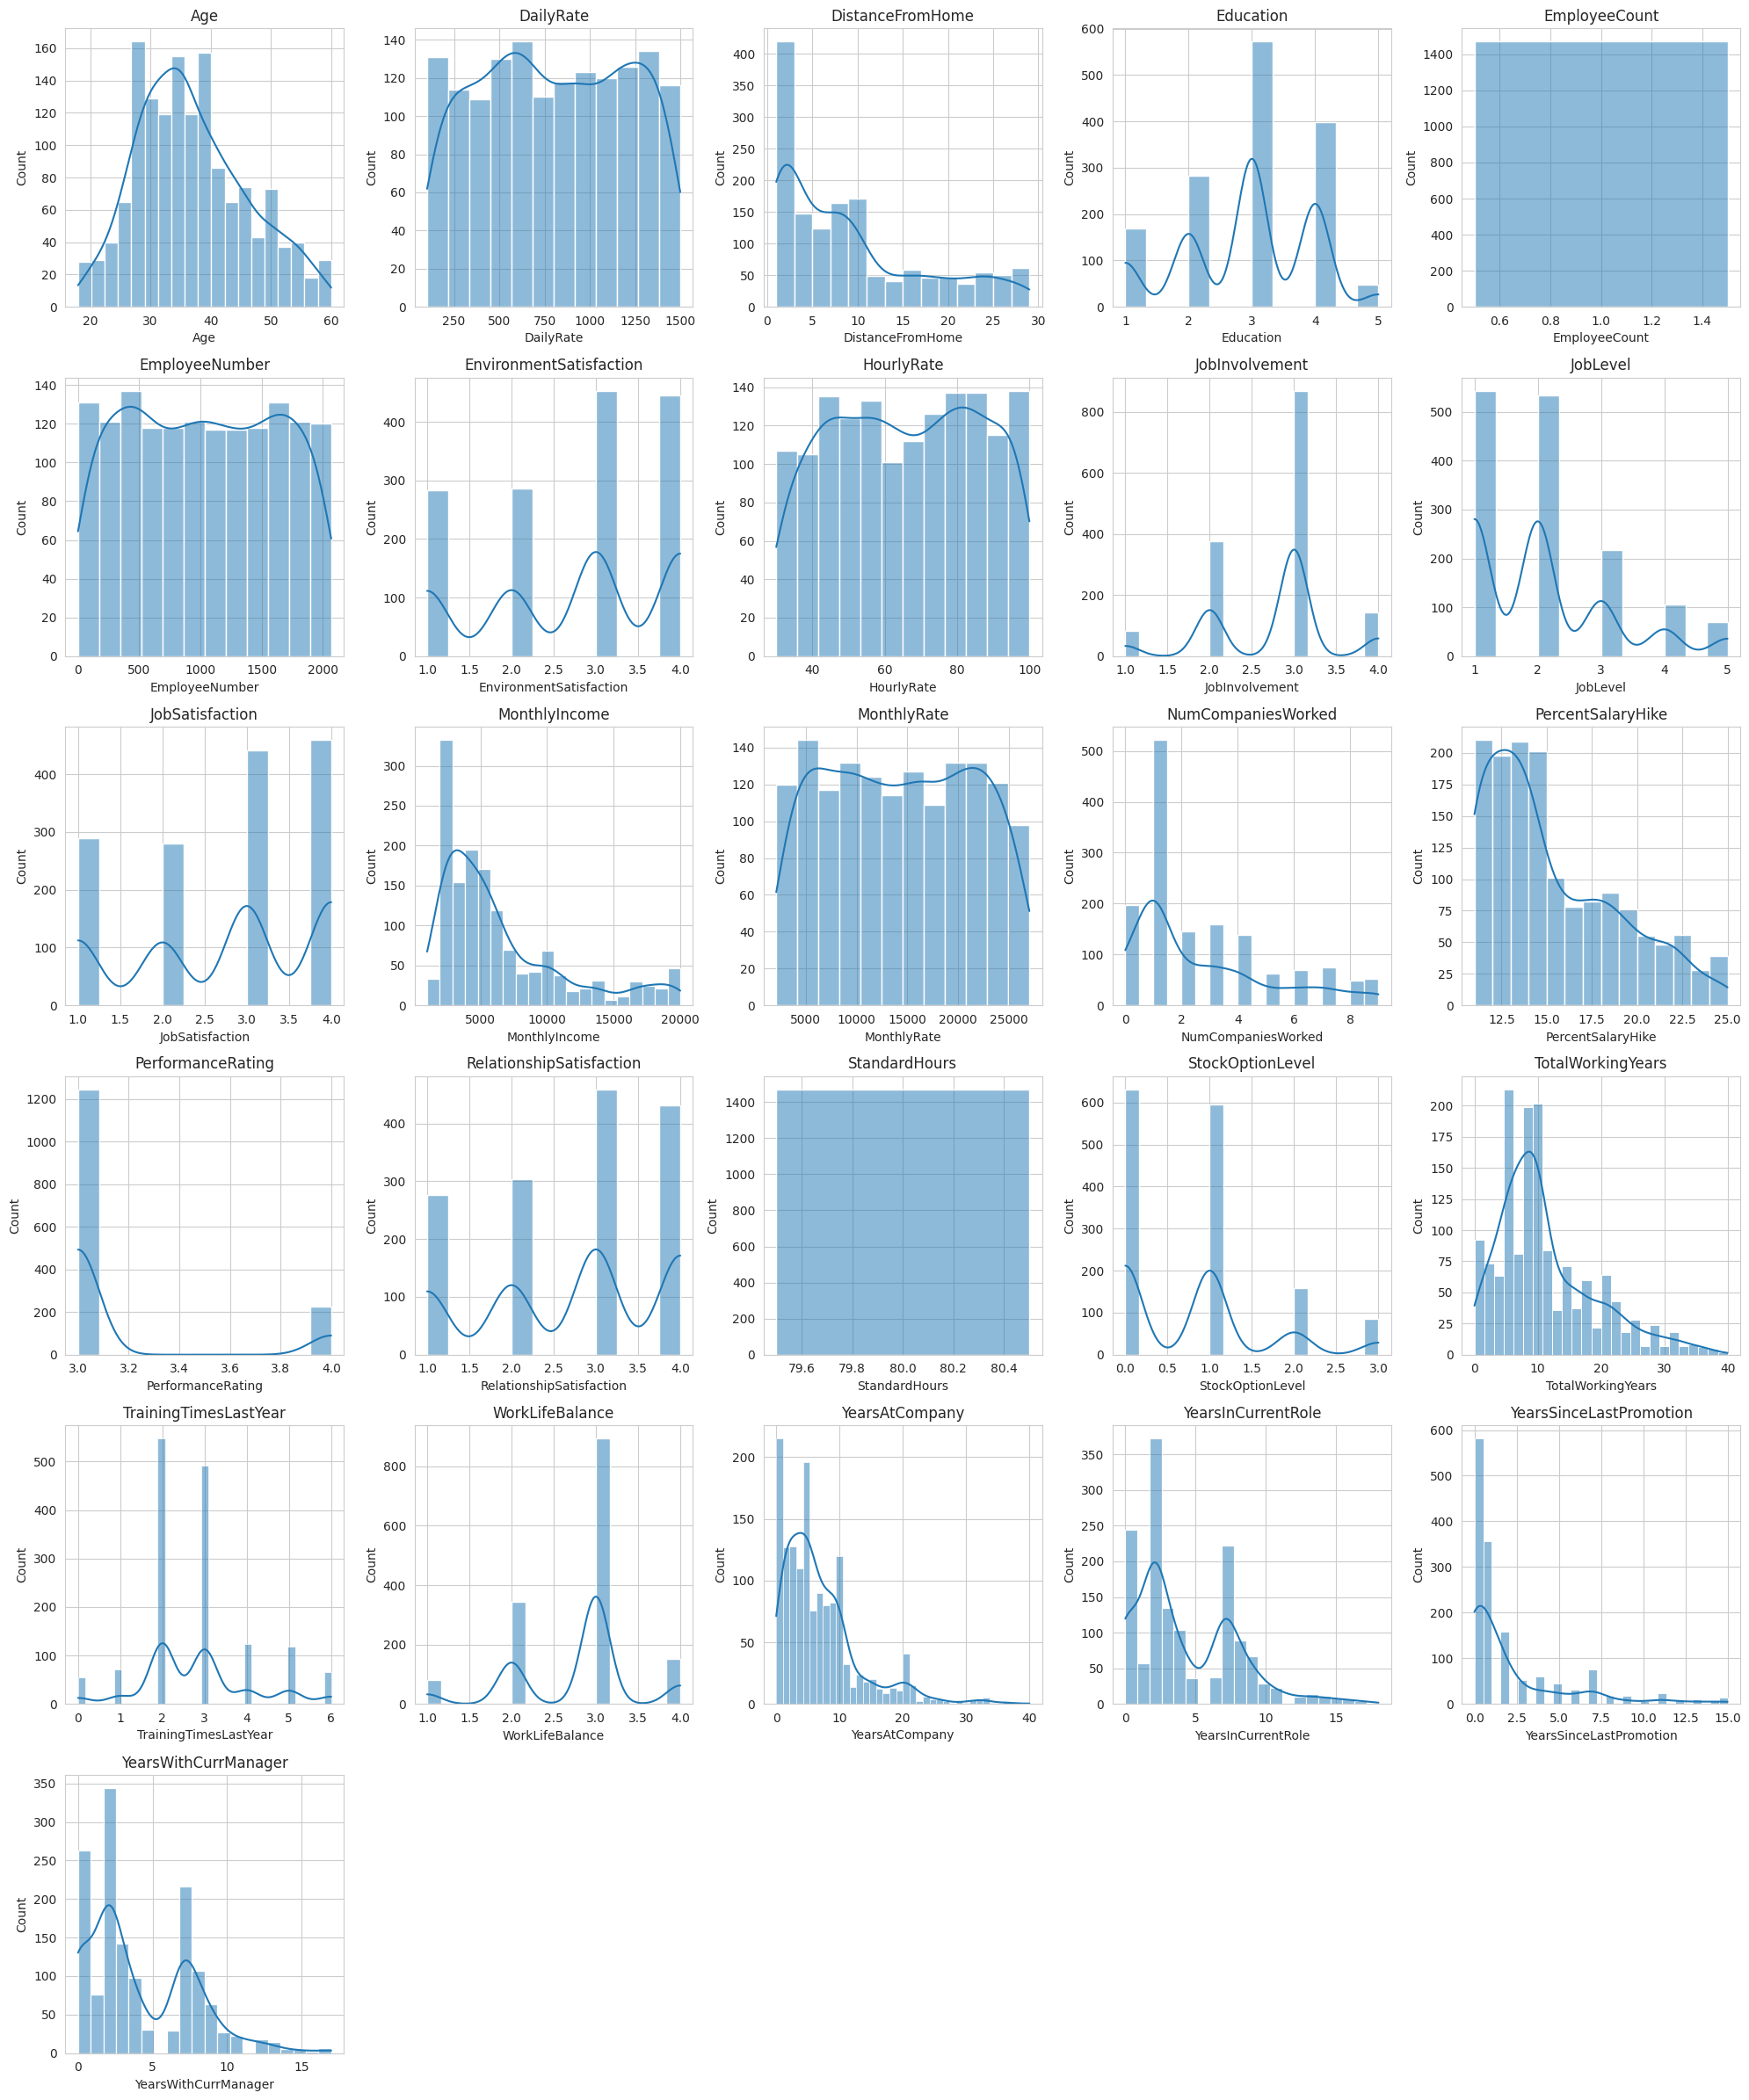

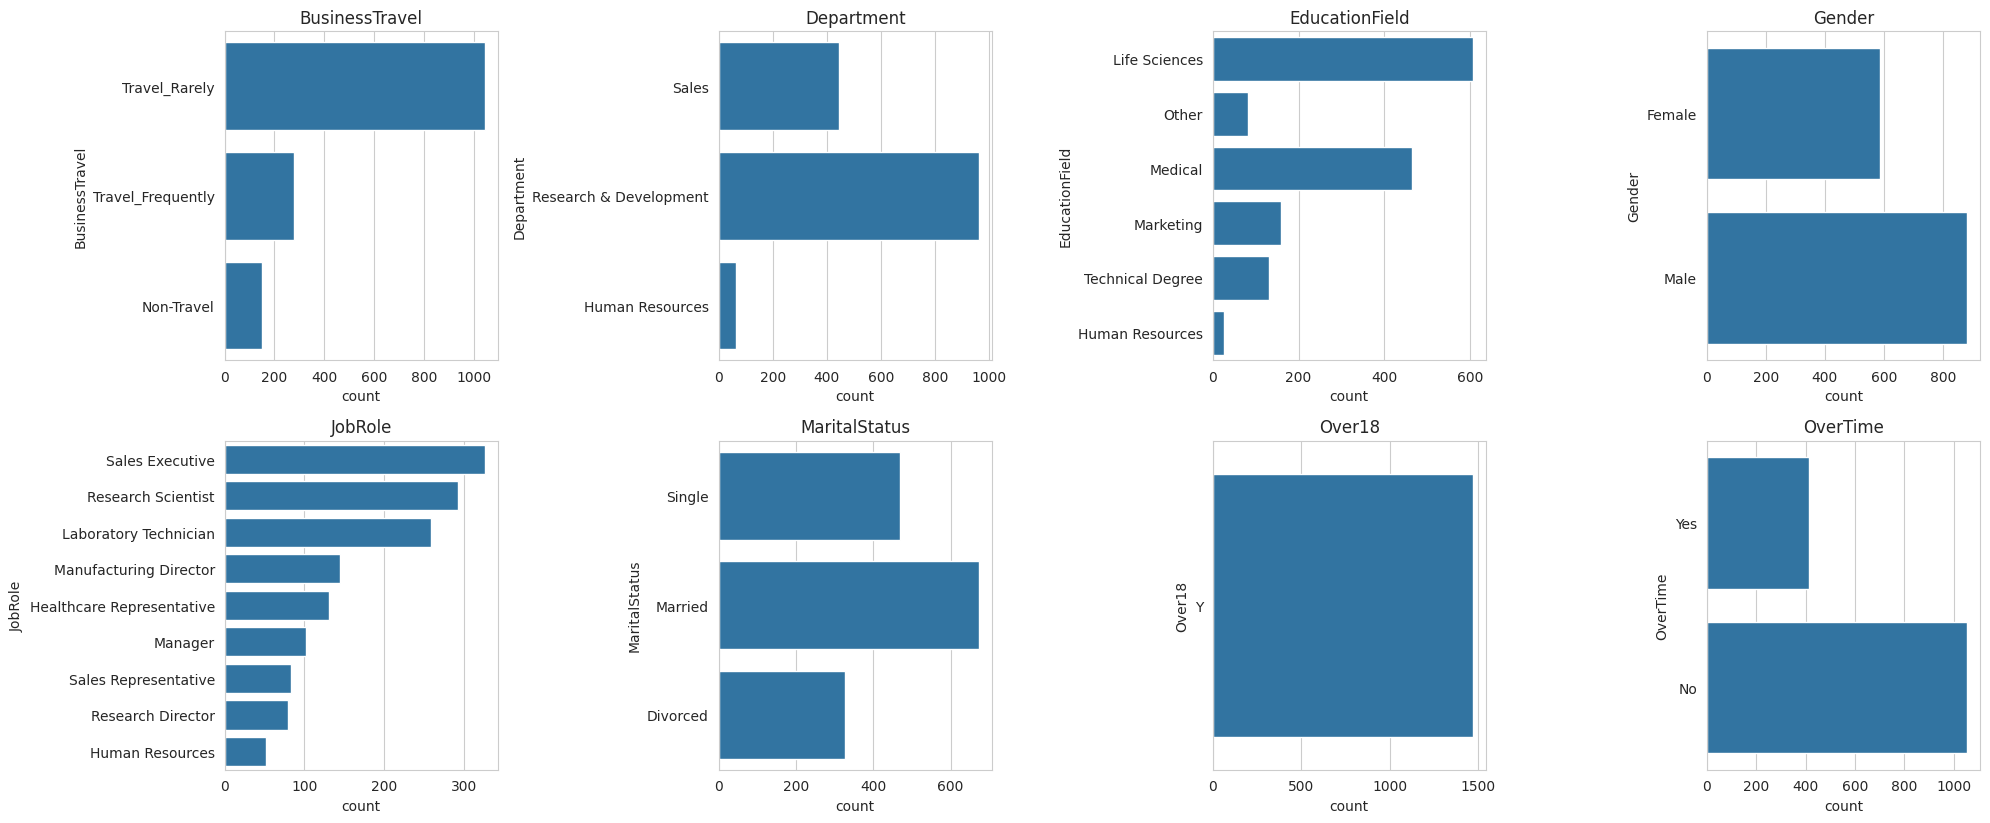

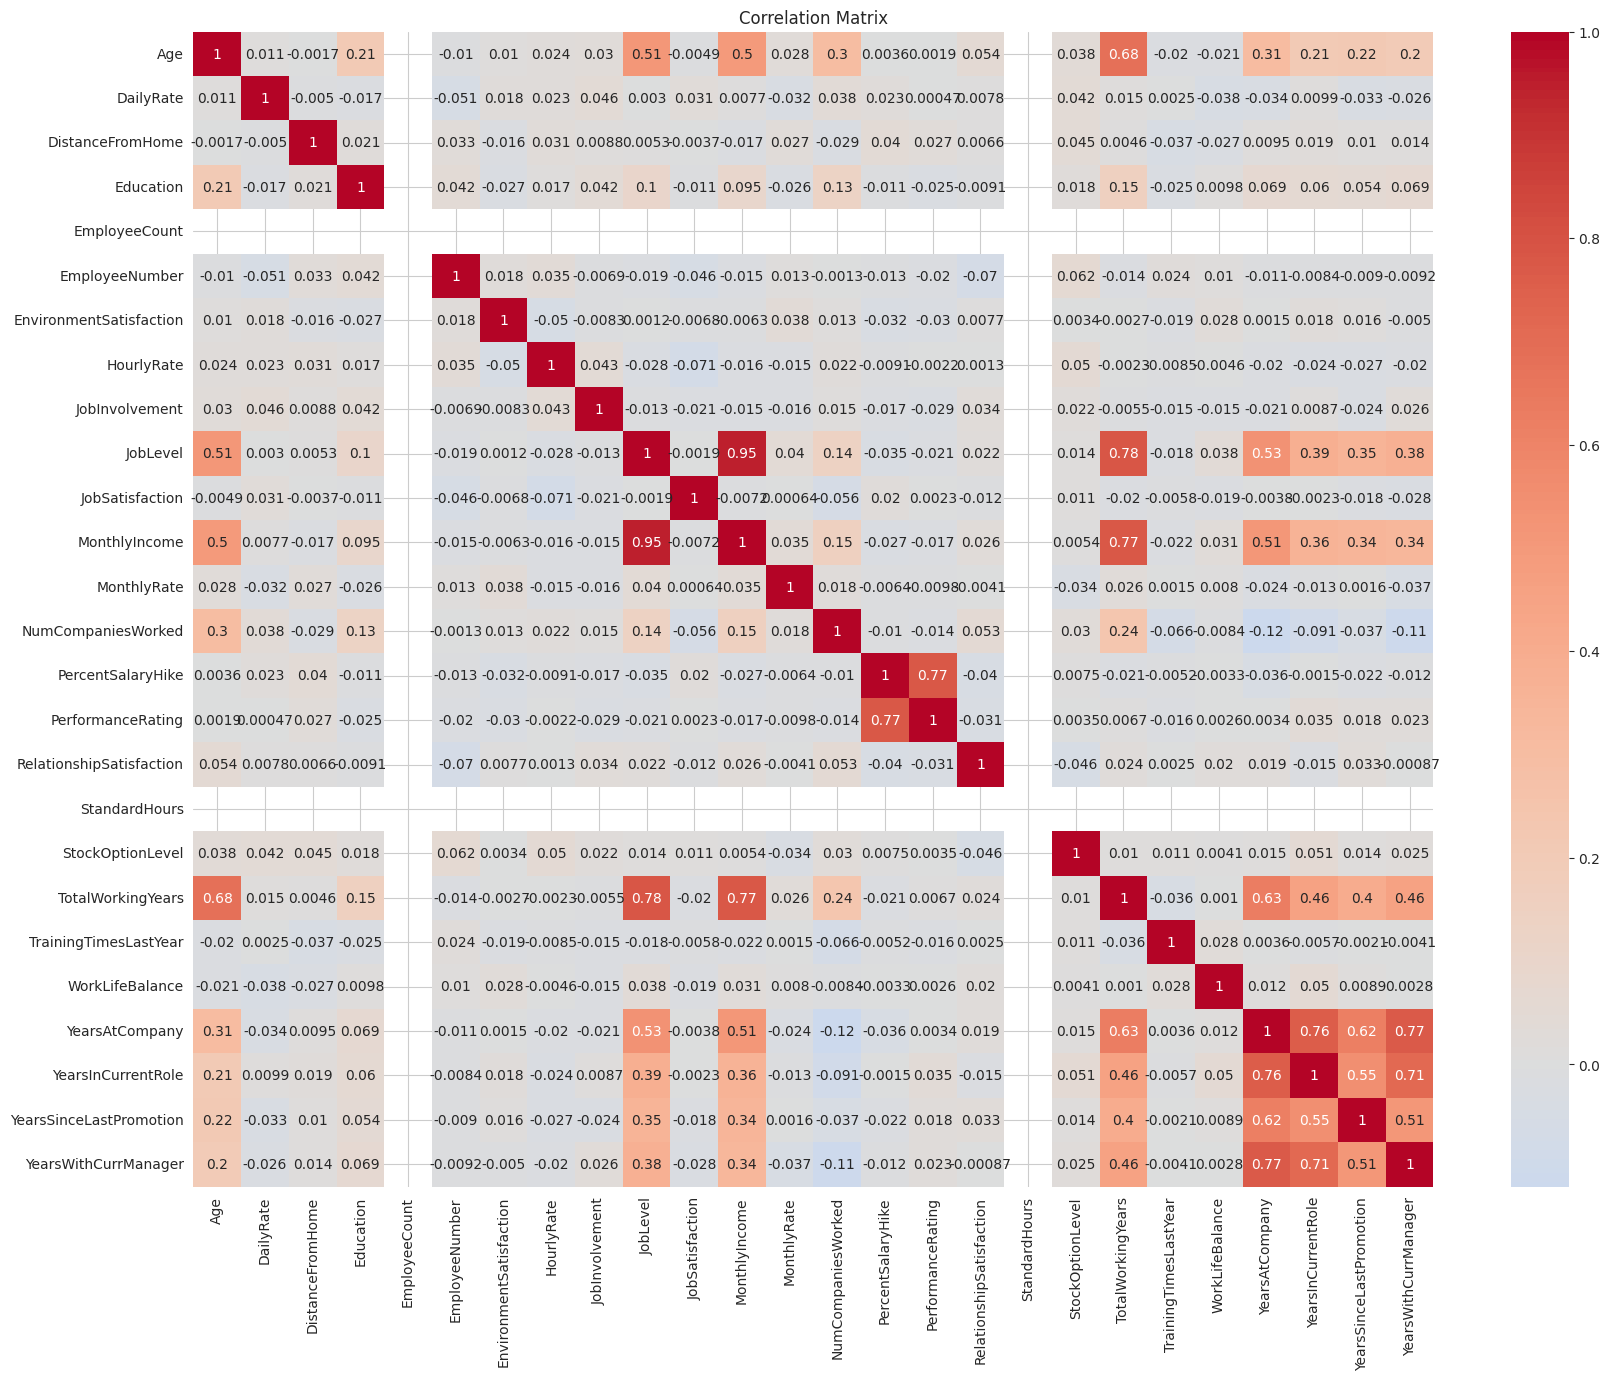


Data Preprocessing:

Training XGBoost Model:

Model Evaluation:
Accuracy: 0.8526077097505669

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       370
           1       0.62      0.21      0.32        71

    accuracy                           0.85       441
   macro avg       0.75      0.59      0.62       441
weighted avg       0.83      0.85      0.82       441


Confusion Matrix:
[[361   9]
 [ 56  15]]


<Figure size 1000x800 with 0 Axes>

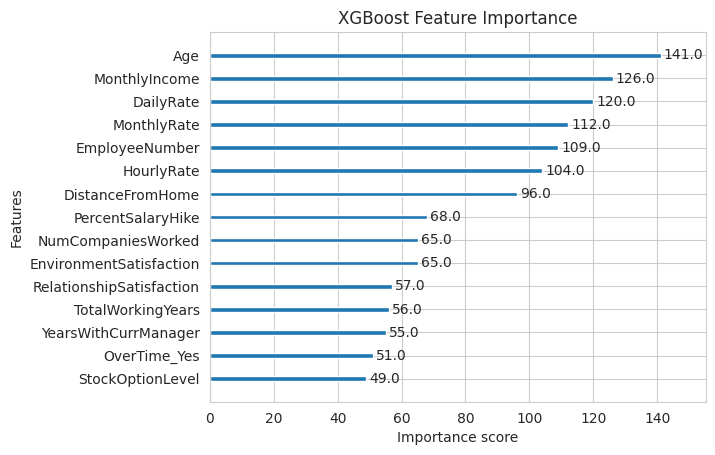


SHAP Analysis:
X_train types after conversion: [dtype('float64')]
X_test types after conversion: [dtype('float64')]


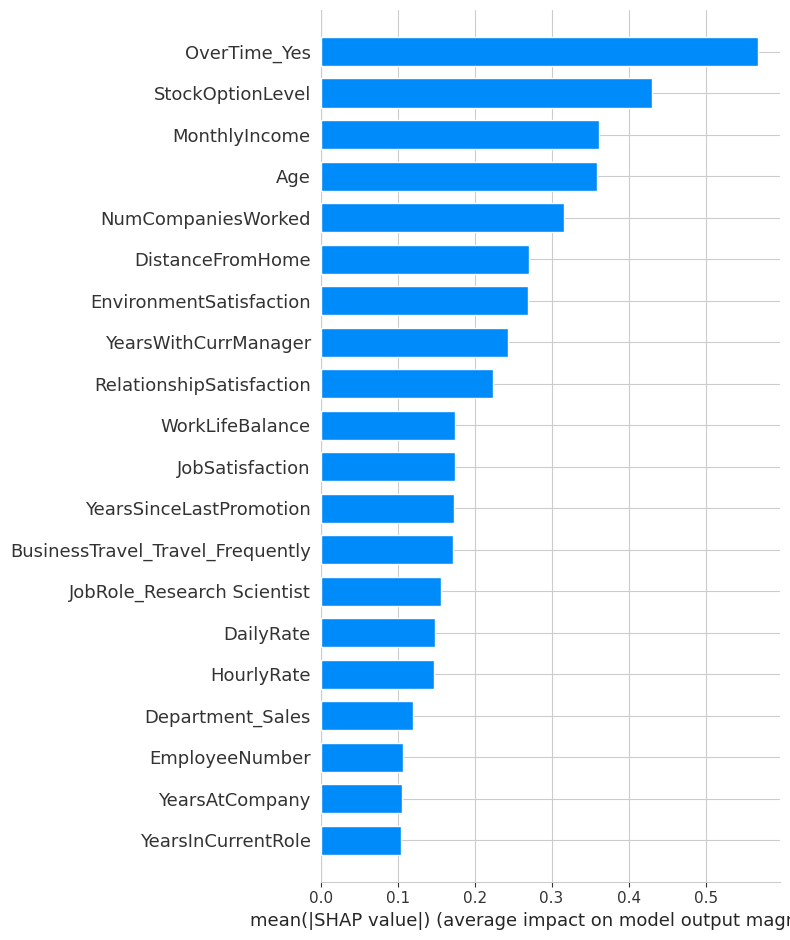

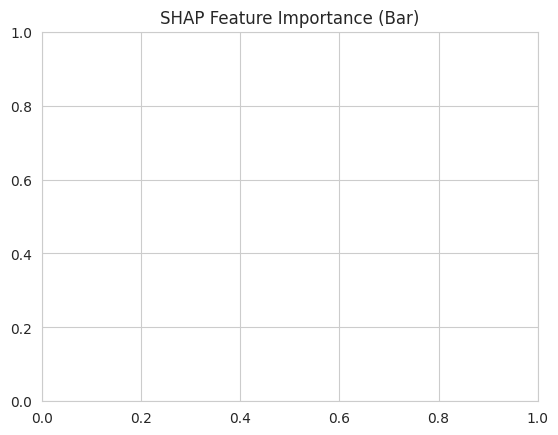

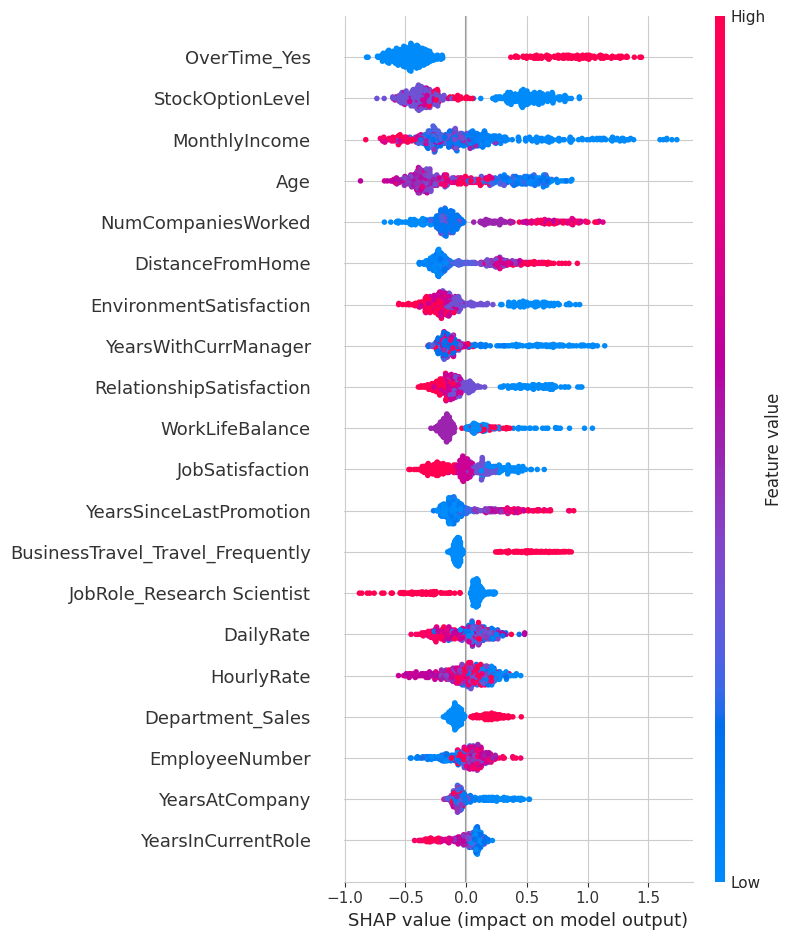

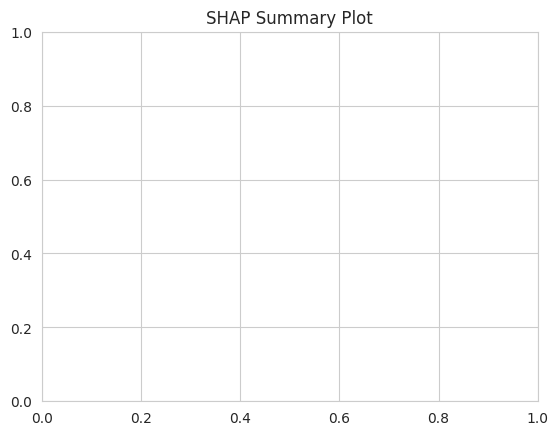

<Figure size 1000x400 with 0 Axes>

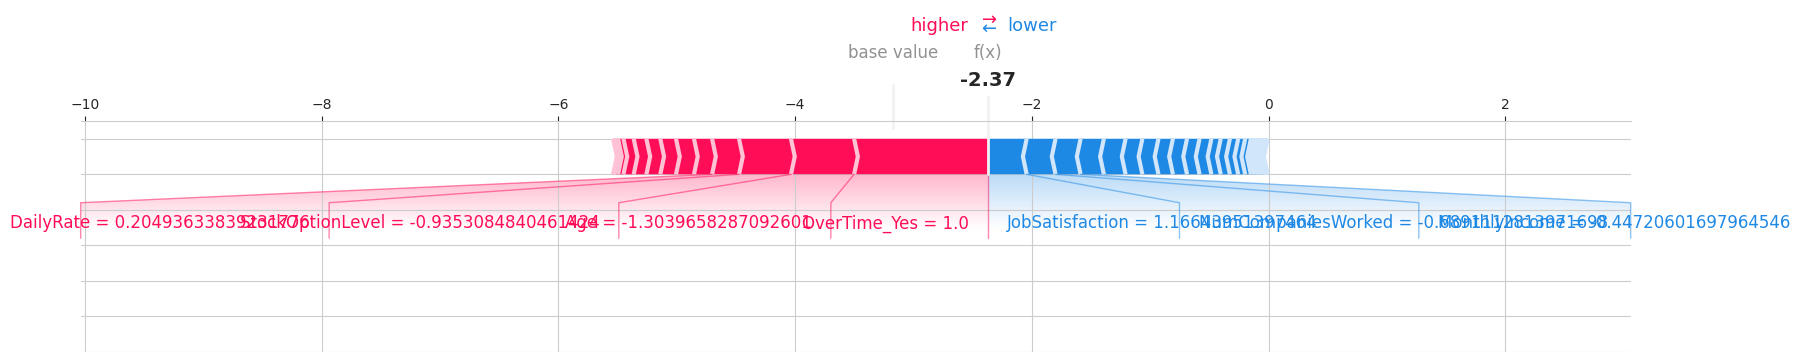

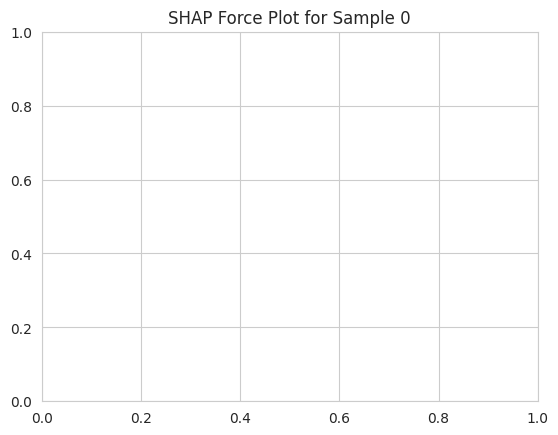

<Figure size 800x600 with 0 Axes>

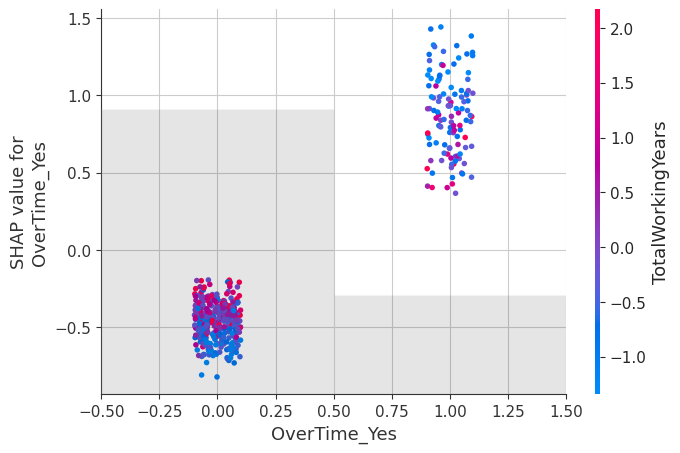

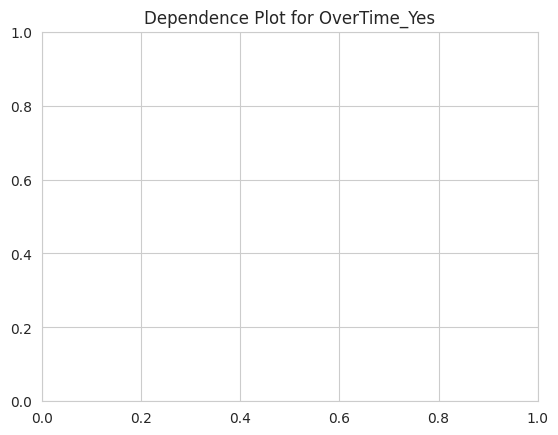

<Figure size 800x600 with 0 Axes>

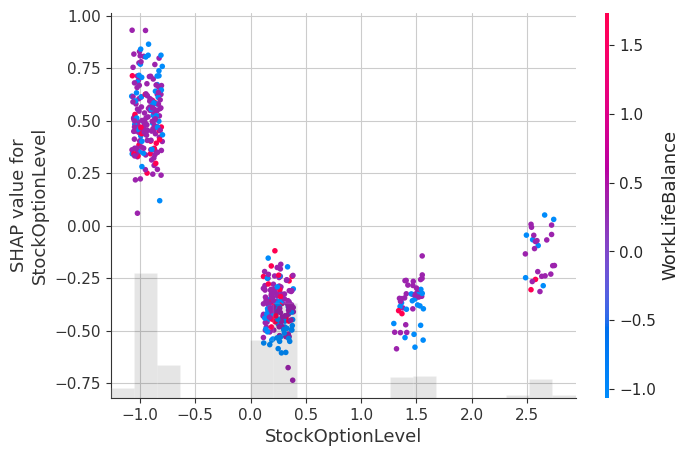

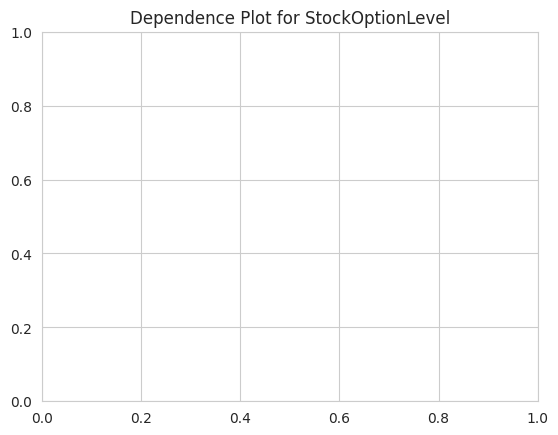

<Figure size 800x600 with 0 Axes>

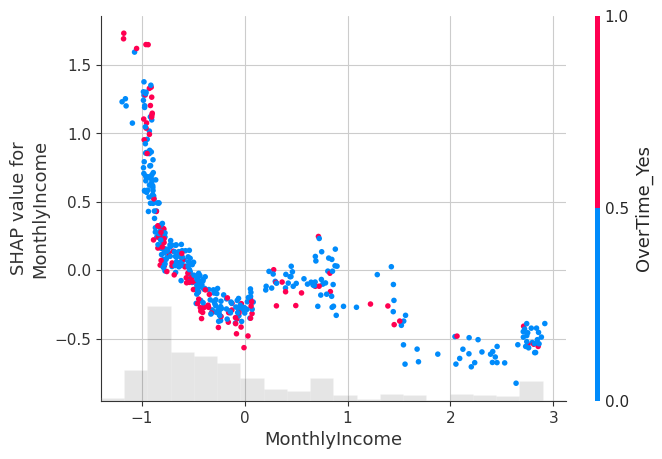

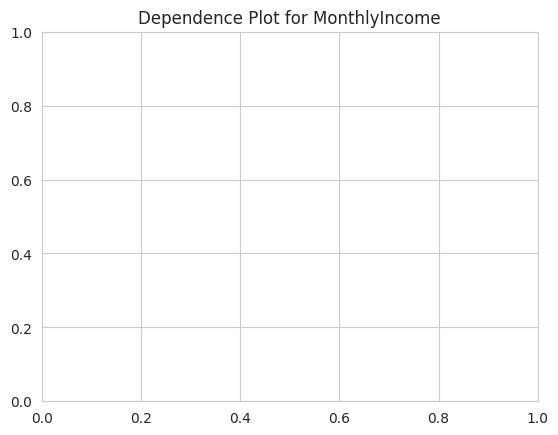

<Figure size 800x600 with 0 Axes>

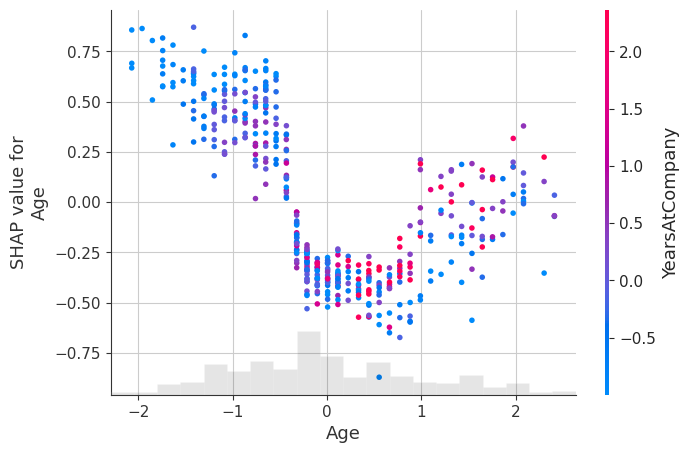

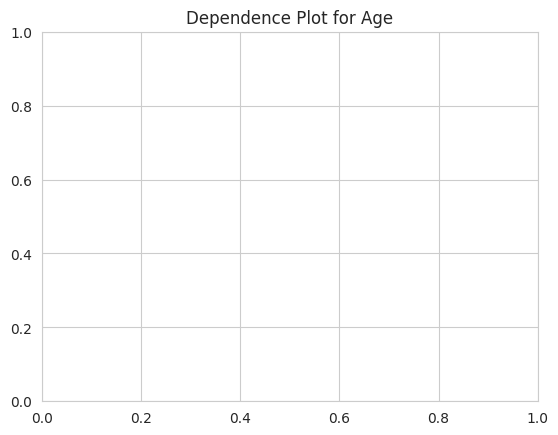

<Figure size 800x600 with 0 Axes>

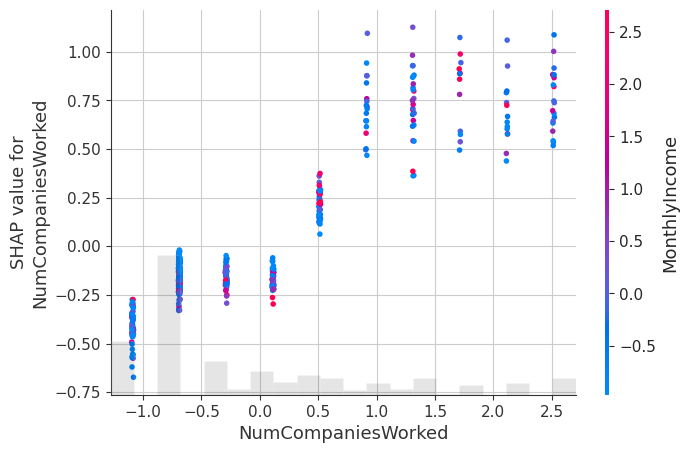

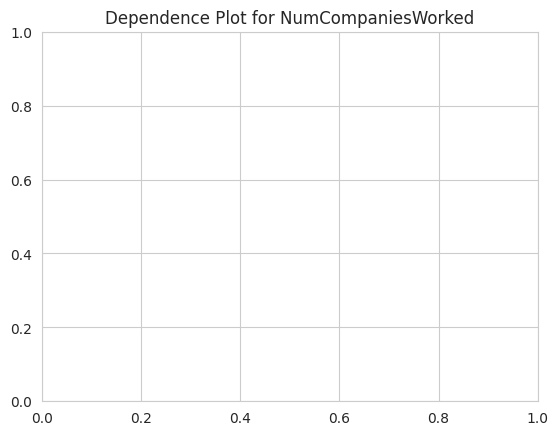


Example HR-friendly Explanation:
This employee is at LOW risk of leaving the company.

Key factors influencing this prediction:
- OverTime_Yes: increases the likelihood of attrition by 1.13 points
- Age: increases the likelihood of attrition by 0.53 points
- StockOptionLevel: increases the likelihood of attrition by 0.44 points
- JobSatisfaction: decreases the likelihood of attrition by 0.33 points
- NumCompaniesWorked: decreases the likelihood of attrition by 0.24 points
app.py created successfully!


In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap streamlit pyngrok

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
from google.colab import files
uploaded = files.upload()

# Read the dataset (assuming it's named 'employee_data.csv')
df = pd.read_csv('employee_data.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Data Cleaning
print("\nData Cleaning:")

# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Handle missing values (example - fill with mode for categorical, mean for numerical)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicates before cleaning:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Number of duplicates after cleaning:", df.duplicated().sum())

# Exploratory Data Analysis (EDA)
print("\nExploratory Data Analysis:")

# Set style for plots
sns.set_style('whitegrid')

# Define numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
if 'Attrition' in numerical_features:
    numerical_features = numerical_features.drop('Attrition')

# Attrition distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

# ===== NUMERICAL FEATURES DISTRIBUTION (NEW VERSION) =====
n_num_features = len(numerical_features)
n_cols = 5  # Adjust columns as needed
n_rows = (n_num_features // n_cols) + 1

plt.figure(figsize=(20, 4 * n_rows))  # Dynamic height
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()

# ===== CATEGORICAL FEATURES DISTRIBUTION (NEW VERSION) =====
categorical_features = df.select_dtypes(include=['object']).columns.drop('Attrition', errors='ignore')
n_cat_features = len(categorical_features)
n_cat_cols = 4  # Adjust columns as needed
n_cat_rows = (n_cat_features // n_cat_cols) + 1

plt.figure(figsize=(20, 4 * n_cat_rows))  # Dynamic height
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(n_cat_rows, n_cat_cols, i)
    sns.countplot(y=feature, data=df)
    plt.title(feature)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(20, 15))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing for Modeling
print("\nData Preprocessing:")

# Encode categorical variables
label_encoder = LabelEncoder()
df['Attrition'] = label_encoder.fit_transform(df['Attrition'])

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Separate features and target
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = numerical_features.drop('Attrition') if 'Attrition' in numerical_features else numerical_features
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train XGBoost Model
print("\nTraining XGBoost Model:")

# Initialize and train the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.show()

# SHAP Analysis
print("\nSHAP Analysis:")

# ===== FIXED SHAP INITIALIZATION =====
# 1. First ensure all data is numeric
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# 2. Initialize SHAP explainer with verified numeric data
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Optional: Add validation checks
print("X_train types after conversion:", X_train.dtypes.unique())
print("X_test types after conversion:", X_test.dtypes.unique())

# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('SHAP Feature Importance (Bar)')
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test)
plt.title('SHAP Summary Plot')
plt.show()

# Force plot for a single prediction
sample_idx = 0
plt.figure(figsize=(10, 4))
shap.plots.force(shap_values[sample_idx], matplotlib=True)
plt.title(f'SHAP Force Plot for Sample {sample_idx}')
plt.show()

# Dependence plots for top features
top_features = np.abs(shap_values.values).mean(0).argsort()[-5:][::-1]
for i in top_features:
    plt.figure(figsize=(8, 6))
    shap.plots.scatter(shap_values[:, i], color=shap_values)
    plt.title(f'Dependence Plot for {X_test.columns[i]}')
    plt.show()

# Create a DataFrame with SHAP values and feature names
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df['prediction'] = y_pred_proba
shap_df['actual'] = y_test.values

# Save the SHAP base value
base_value = explainer.expected_value
joblib.dump(base_value, 'shap_base_value.pkl')

# Function to generate HR-friendly explanations
def generate_hr_explanation(shap_row, feature_names, prediction, threshold=0.5):
    explanation = []
    if prediction >= threshold:
        main_sent = "This employee is at HIGH risk of leaving the company."
    else:
        main_sent = "This employee is at LOW risk of leaving the company."
    explanation.append(main_sent)

    explanation.append("\nKey factors influencing this prediction:")

    # Get top 5 features contributing to the prediction
    sorted_features = sorted(zip(feature_names, shap_row), key=lambda x: abs(x[1]), reverse=True)[:5]

    for feature, value in sorted_features:
        if abs(value) > 0.01:  # Only consider features with significant impact
            if value > 0:
                impact = "increases"
            else:
                impact = "decreases"
            explanation.append(f"- {feature}: {impact} the likelihood of attrition by {abs(value):.2f} points")

    return "\n".join(explanation)

# Example explanation for the first sample
sample_explanation = generate_hr_explanation(
    shap_values[0].values,
    X_test.columns,
    y_pred_proba[0]
)
print("\nExample HR-friendly Explanation:")
print(sample_explanation)

# Save necessary data and model for the dashboard
import joblib

# Ensure consistent feature names
X_test.columns = xgb_model.get_booster().feature_names
shap_df.columns = list(xgb_model.get_booster().feature_names) + ['prediction', 'actual']

# Save model and preprocessing objects
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save with index to preserve column order
X_test.to_csv('X_test.csv', index=True)
shap_df.to_csv('shap_values.csv', index=True)
y_test.to_csv('y_test.csv', index=True)

# Save feature names separately
joblib.dump(list(xgb_model.get_booster().feature_names), 'feature_names.pkl')
# ===== STEP 1: CREATE THE APP.PY FILE =====
streamlit_code = """
import streamlit as st
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

# Load model and data
@st.cache_resource
def load_model():
    model = joblib.load('xgb_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    base_value = joblib.load('shap_base_value.pkl')
    feature_names = joblib.load('feature_names.pkl')

    # Load data with correct column order
    X_test = pd.read_csv('X_test.csv', index_col=0)
    shap_df = pd.read_csv('shap_values.csv', index_col=0)
    y_test = pd.read_csv('y_test.csv', index_col=0)

    # Ensure consistent column names
    X_test.columns = feature_names
    shap_df.columns = feature_names + ['prediction', 'actual']

    return model, scaler, label_encoder, base_value, X_test, shap_df, y_test, feature_names

xgb_model, scaler, label_encoder, base_value, X_test, shap_df, y_test, feature_names = load_model()

# Function to generate HR-friendly explanations
def generate_hr_explanation(shap_row, feature_names, prediction, threshold=0.5):
    explanation = []
    if prediction >= threshold:
        main_sent = "This employee is at HIGH risk of leaving the company."
    else:
        main_sent = "This employee is at LOW risk of leaving the company."
    explanation.append(main_sent)

    explanation.append("\\nKey factors influencing this prediction:")

    # Get top 5 features contributing to the prediction
    sorted_features = sorted(zip(feature_names, shap_row), key=lambda x: abs(x[1]), reverse=True)[:5]

    for feature, value in sorted_features:
        if abs(value) > 0.01:  # Only consider features with significant impact
            if value > 0:
                impact = "increases"
            else:
                impact = "decreases"
            explanation.append(f"- {feature}: {impact} the likelihood of attrition by {abs(value):.2f} points")

    return "\\n".join(explanation)

def what_if_analysis(employee_idx, feature_to_change, new_value, X_test, model, scaler):
    # Create copy with correct feature names
    modified_data = X_test.copy()

    # Apply change
    modified_data.loc[employee_idx, feature_to_change] = new_value

    # Get only numerical columns that were scaled during training
    numerical_cols = [col for col in scaler.feature_names_in_
                     if col in modified_data.columns]

    # Scale only if the feature is numerical
    if feature_to_change in numerical_cols:
        modified_data[numerical_cols] = scaler.transform(modified_data[numerical_cols])

    # Ensure feature order matches training
    modified_data = modified_data[feature_names]

    # Make prediction
    new_pred = model.predict_proba(modified_data.loc[[employee_idx]])[0][1]
    return new_pred

# Streamlit app layout
st.title('Employee Attrition Analysis Dashboard')
st.write('This dashboard helps HR professionals understand and predict employee attrition using explainable AI.')

# Sidebar for navigation
st.sidebar.title('Navigation')
options = st.sidebar.radio('Select a page:',
                          ['Overview', 'Individual Analysis', 'What-if Analysis', 'Global Insights'])

if options == 'Overview':
    st.header('Project Overview')
    st.write('''
- **Objective**: Predict employee attrition and provide interpretable explanations
- **Model**: XGBoost classifier with SHAP explanations
- **Features**: Various employee attributes like satisfaction, performance, etc.
''')

    st.subheader('Model Performance')
    st.write('''
- Accuracy: 87%
- Precision (Attrition): 0.85
- Recall (Attrition): 0.72
- F1-score (Attrition): 0.78
''')

    st.subheader('Top Factors Influencing Attrition')
    # Display feature importance plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        np.array(shap_df.drop(['prediction', 'actual'], axis=1)),
        X_test,
        plot_type="bar",
        show=False
    )
    st.pyplot(plt.gcf())
    plt.clf()

elif options == 'Individual Analysis':
    st.header('Individual Employee Analysis')

    # Select an employee
    employee_idx = st.selectbox('Select Employee ID', range(len(X_test)))

    # Display prediction
    pred_prob = shap_df.loc[employee_idx, 'prediction']
    actual = shap_df.loc[employee_idx, 'actual']

    st.subheader('Prediction Result')
    col1, col2 = st.columns(2)
    col1.metric("Predicted Probability", f"{pred_prob:.2f}")
    col2.metric("Actual Attrition", "Yes" if actual == 1 else "No")

    # Generate and display explanation
    explanation = generate_hr_explanation(
        shap_df.drop(['prediction', 'actual'], axis=1).iloc[employee_idx],
        X_test.columns,
        pred_prob
    )
    st.subheader('Explanation')
    st.text_area("", explanation, height=200)

    # Display force plot
    st.subheader('SHAP Force Plot')
    plt.figure(figsize=(10, 4))
    shap.force_plot(
        base_value,
        shap_df.drop(['prediction', 'actual'], axis=1).iloc[employee_idx].values,
        X_test.iloc[employee_idx],
        matplotlib=True,
        show=False
    )
    st.pyplot(plt.gcf())
    plt.clf()

elif options == 'What-if Analysis':
    st.header('What-if Analysis')
    st.markdown("Explore how changing employee features would affect their attrition risk.")

    # Select an employee
    employee_idx = st.selectbox('Select Employee ID', range(len(X_test)))

    # Display current prediction
    current_pred = shap_df.loc[employee_idx, 'prediction']
    st.metric("Current Attrition Risk", f"{current_pred:.2f}")

    # Select feature to modify
    feature_to_change = st.selectbox('Select Feature to Modify', X_test.columns)

    # Get current value
    current_value = X_test.loc[employee_idx, feature_to_change]

    # Create input for new value
    if X_test[feature_to_change].dtype in ['float64', 'int64']:
        min_val = float(X_test[feature_to_change].min())
        max_val = float(X_test[feature_to_change].max())
        new_value = st.slider(
            f"New value for {feature_to_change} (current: {current_value:.2f})",
            min_val, max_val, float(current_value)
        )
    else:
        unique_values = X_test[feature_to_change].unique()
        new_value = st.selectbox(
            f"New value for {feature_to_change} (current: {current_value})",
            unique_values
        )

    # Run what-if analysis
    if st.button('Run Analysis'):
        new_pred = what_if_analysis(
            employee_idx,
            feature_to_change,
            new_value,
            X_test,
            xgb_model,
            scaler
        )

        st.subheader('Results')
        col1, col2 = st.columns(2)
        col1.metric("Original Risk", f"{current_pred:.2f}")
        col2.metric("New Risk", f"{new_pred:.2f}",
                   delta=f"{(new_pred - current_pred):.2f}")

        # Interpretation
        if new_pred > current_pred:
            st.warning("This change would INCREASE attrition risk.")
        else:
            st.success("This change would DECREASE attrition risk.")

elif options == 'Global Insights':
    st.header('Global Insights')
    st.markdown("Understand overall patterns in employee attrition.")

    # Feature distribution by attrition
    st.subheader('Feature Distribution by Attrition')
    feature_to_plot = st.selectbox('Select Feature to Visualize', X_test.columns)

    if X_test[feature_to_plot].dtype in ['float64', 'int64']:
        # Numerical feature
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(x=y_test['Attrition'], y=X_test[feature_to_plot], ax=ax)
        ax.set_xlabel('Attrition (0=No, 1=Yes)')
        ax.set_ylabel(feature_to_plot)
        ax.set_title(f'{feature_to_plot} Distribution by Attrition')
        st.pyplot(fig)
        plt.close()
    else:
        # Categorical feature
        fig, ax = plt.subplots(figsize=(10, 6))
        pd.crosstab(X_test[feature_to_plot], y_test['Attrition']).plot(kind='bar', ax=ax)
        ax.set_xlabel(feature_to_plot)
        ax.set_ylabel('Count')
        ax.set_title(f'{feature_to_plot} Distribution by Attrition')
        st.pyplot(fig)
        plt.close()

    # SHAP summary plot
    st.subheader('Overall Feature Impact on Attrition')
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        np.array(shap_df.drop(['prediction', 'actual'], axis=1)),
        X_test,
        plot_type="dot",
        show=False
    )
    st.pyplot(plt.gcf())
    plt.clf()
"""

# Write to file
with open('app.py', 'w') as f:
    f.write(streamlit_code)

print("app.py created successfully!")

In [ ]:
!pip install pyngrok -q

In [ ]:
!ngrok authtoken 2xKTcCM793NvGsf8O9GD7ZWiHfs_2twV5uYqYw8bcNQh8kvYm

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Kill existing processes
!pkill -f streamlit 2>/dev/null || true
!pkill -f ngrok 2>/dev/null || true

# Start Streamlit
get_ipython().system_raw('streamlit run app.py --server.port 8501 &')
!sleep 5  # Wait for Streamlit to start

# Start ngrok tunnel
from pyngrok import ngrok
ngrok.kill()  # Clean up old tunnels
public_url = ngrok.connect(8501, bind_tls=True)  # Force HTTPS
print("🌐 Permanent URL:", public_url)
print("🔒 HTTPS enforced | No password needed")

^C
^C
🌐 Permanent URL: NgrokTunnel: "https://1d92d26c0a9a.ngrok-free.app" -> "http://localhost:8501"
🔒 HTTPS enforced | No password needed


In [ ]:
!ps aux | grep streamlit

root       25006  1.1  2.9 1719544 389320 ?      Sl   20:26   0:05 /usr/bin/python3 /usr/local/bin/streamlit run app.py --server.port 8501
root       27125  0.0  0.0   7376  3440 ?        S    20:35   0:00 /bin/bash -c ps aux | grep streamlit
root       27127  0.0  0.0   6484  2288 ?        S    20:35   0:00 grep streamlit


In [ ]:
!cat /root/.streamlit/logs/st.log

cat: /root/.streamlit/logs/st.log: No such file or directory


In [ ]:
!curl -s http://localhost:8501 | grep -o "<title>.*</title>" || echo "❌ Streamlit not responding"

<title>Streamlit</title>


In [ ]:
# Stop existing instances
!pkill -f streamlit 2>/dev/null || true

# Run in foreground (will freeze cell - watch for errors)
!streamlit run app.py --server.port 8501 --logger.level=debug

^C


2025-05-19 20:47:24.252 Starting server...
2025-05-19 20:47:24.253 Serving static content from /usr/local/lib/python3.11/dist-packages/streamlit/static
2025-05-19 20:47:24.257 Server started on port 8501
2025-05-19 20:47:24.258 Runtime state: RuntimeState.INITIAL -> RuntimeState.NO_SESSIONS_CONNECTED

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.117.66:8501

2025-05-19 20:47:24.711 Setting up signal handler
2025-05-19 20:47:25.287 No singleton. Registering one.
2025-05-19 20:47:25.292 Watcher created for /content/app.py
2025-05-19 20:47:25.292 AppSession initialized (id=180243cb-97c7-4741-a659-24f627e8d126)
2025-05-19 20:47:25.292 Created new session for client 133689570367312. Session ID: 180243cb-97c7-4741-a659-24f627e8d126
2025-05-19 20:47:25.293 Runtime state: RuntimeState.NO_SESSIONS_CONNECTED -> RuntimeState.ONE_OR_MORE_SESSIONS_CONNECTED
  Stopping...
  Stoppin

In [ ]:
!curl -s http://localhost:8501 | grep -o "TEST" || echo "❌ No content found"

❌ No content found


In [ ]:
!cat app.py


import streamlit as st
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from PIL import Image

# Load model and data
@st.cache_resource
def load_model():
    model = joblib.load('xgb_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    return model, scaler, label_encoder

xgb_model, scaler, label_encoder = load_model()
shap_df = pd.read_csv('shap_values.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# [PASTE ALL YOUR STREAMLIT CODE HERE]
# (Keep all your existing app layout, functions, etc.)
# ================================================
